In [297]:
!pip install transformers

In [298]:
import torch
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

In [299]:
# text = "안녕하세요. 저는 부산광역시 동의대학교에 재학 중인 한윤진입니다. 동의하세요? 그럼 안녕"
text = "뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아"

marked_text = "[CLS] " + text + " [SEP]"

tokenized_text = tokenizer.tokenize(marked_text)

indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
뭐             9,303
##야          21,711
이             9,638
평             9,926
##점          34,907
##들은         22,879
.               119
.               119
.               119
.               119
나             8,982
##쁘          119,022
##진          18,623
않             9,523
##지만         28,578
10           10,150
##점          34,907
짜             9,715
##리는         26,344
더             9,074
##더          54,141
##욱          119,168
[UNK]           100
[SEP]           102


In [300]:
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [301]:
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [302]:
model = BertModel.from_pretrained('bert-base-multilingual-cased',
                                  output_hidden_states = True,
                                  output_attentions = True,
#                                  keep_multihead_output = True
                                  )

model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [303]:
with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)

    token_output = outputs[0]
    pooler_output = outputs[1]
    hidden_states = outputs[2]
    # outputs[0] :  단어마다 개별적으로 벡터 표현
    # outputs[1] : pooler 출력, 전체 시퀀스 벡터 표현
    # outputs[2] : 레이어마다 단어 벡터 표현
    # outputs[3] : output_attentions

In [304]:
print(outputs[-1][0].shape)

torch.Size([1, 12, 25, 25])


In [305]:
print(outputs[0].shape)
# batches: 1
# tokens: 22
# hidden units: 768

print(outputs[1].shape)
# batches: 1
# hidden units: 768

print(len(outputs[2]))
# layers: 13(index 0 + 12 hidden layers)

print(outputs[2][0].shape)
# batches: 1
# tokens: 22
# hidden units: 768

print(len(outputs[3]))
# layers: 12

print(outputs[3][0].shape)
# batches: 1
# Heads: 12
# tokens: 22
# tokens: 22

torch.Size([1, 25, 768])
torch.Size([1, 768])
13
torch.Size([1, 25, 768])
12
torch.Size([1, 12, 25, 25])


In [306]:
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 25, 768])

In [307]:
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 25, 768])

In [308]:
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([25, 13, 768])

In [309]:
import matplotlib.pyplot as plt

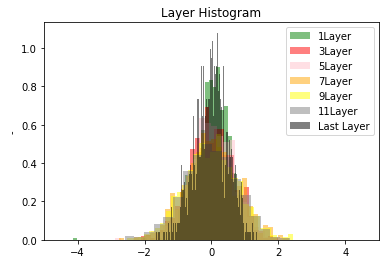

In [310]:
plt.hist(token_embeddings[7][1], alpha=0.5, bins=100, density=True, histtype='bar', color='green', label='1Layer') #'저'에 대한 레이어마다의 output
plt.hist(token_embeddings[7][3], alpha=0.5, bins=100, density=True, histtype='bar', color='red', label='3Layer')
plt.hist(token_embeddings[7][5], alpha=0.5, bins=100, density=True, histtype='bar', color='pink', label='5Layer')
plt.hist(token_embeddings[7][7], alpha=0.5, bins=100, density=True, histtype='bar', color='orange', label='7Layer')
plt.hist(token_embeddings[7][9], alpha=0.5, bins=100, density=True, histtype='bar', color='yellow', label='9Layer')
plt.hist(token_embeddings[7][11], alpha=0.5, bins=100, density=True, histtype='bar', color='gray', label='11Layer')
plt.hist(token_embeddings[7][12], alpha=0.5, bins=100, density=True, histtype='bar', color='black', label='Last Layer')


plt.gca().set(title='Layer Histogram', ylabel='-')
plt.xlim(-5,5)
plt.legend();

In [311]:
token_embeddings2 = token_embeddings.permute(1,0,2)

token_embeddings2.size()

torch.Size([13, 25, 768])

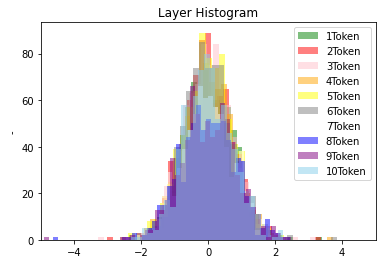

In [312]:
plt.hist(token_embeddings2[7][1], alpha=0.5, bins=100, color='green', label='1Token') #안
plt.hist(token_embeddings2[7][2], alpha=0.5, bins=100, color='red', label='2Token') #녕
plt.hist(token_embeddings2[7][3], alpha=0.5, bins=100, color='pink', label='3Token') #하
plt.hist(token_embeddings2[7][4], alpha=0.5, bins=100, color='orange', label='4Token') #세
plt.hist(token_embeddings2[7][5], alpha=0.5, bins=100, color='yellow', label='5Token') #요
plt.hist(token_embeddings2[7][6], alpha=0.5, bins=100, color='gray', label='6Token') #.
plt.hist(token_embeddings2[7][7], alpha=0.5, bins=100, color='white', label='7Token') #저
plt.hist(token_embeddings2[7][8], alpha=0.5, bins=100, color='blue', label='8Token') #는
plt.hist(token_embeddings2[7][9], alpha=0.5, bins=100, color='purple', label='9Token') #부
plt.hist(token_embeddings2[7][10], alpha=0.5, bins=100, color='skyblue', label='10Token') #산

# 넓게 퍼져있는 데이터일 수록 (0에 가까운 값이 없을 수록) 중요한 데이터?

plt.gca().set(title='Layer Histogram', ylabel='-')
plt.xlim(-5,5)
plt.legend();

In [313]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 [CLS]
1 뭐
2 ##야
3 이
4 평
5 ##점
6 ##들은
7 .
8 .
9 .
10 .
11 나
12 ##쁘
13 ##진
14 않
15 ##지만
16 10
17 ##점
18 짜
19 ##리는
20 더
21 ##더
22 ##욱
23 [UNK]
24 [SEP]


In [314]:
from scipy.spatial.distance import cosine

#same = 1 - cosine(token_output[0][2], token_output[0][35])
#diff = 1 - cosine(token_output[0][13], token_output[0][27])

#print('같은 의미 단어 비교:  %.2f' % same)
#print('다른 의미 단어 비교:  %.2f' % diff)

In [315]:
import tensorflow as tf
import numpy as np
from IPython.core.display import HTML, display

# seed = 1
# torch.cuda.manual_seed(seed)
                       
m = torch.nn.Linear(768, 1, bias=True)
#torch.nn.init.xavier_uniform_(m.weight)\
m.weight.data.fill_(1)
n = torch.nn.ReLU()

In [316]:
print(m.weight)

Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
      

In [317]:
with torch.no_grad():
  def call_html(i, output, token_str):
    color = str(int(round(output*800)))
    print(color)
    aaa = "<script type='text/javascript'> var span = document.createElement('span'); var newContent = document.createTextNode('"+token_str+" '); span.appendChild(newContent); span.style.color='rgb("+color+",0,0)'; document.body.appendChild(span); </script>"
    display(HTML(aaa))
    
  def vis(i, token_str):
    output = m(token_output[0][i])
    output = n(output)
    output= np.max(output.detach().numpy())
    
    call_html(i, output, token_str)

In [318]:
for i, token_str in enumerate(tokenized_text):
  if token_str == "[CLS]" or token_str == "[SEP]"  :
    continue 
    
  vis(i, token_str)

97


0


0


0


0


0


0


0


0


0


0


0


0


0


0


953


378


0


0


0


0


0


0
